USECASE


Here you would need to create a model which assigns a customer to a certain customer category based on the total value of orders they’ve placed. This would let us target the most valuable customers with certain offers which promote a higher spend. 

Import all the required libraries 

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

Reading the DataSet with encoding parameter 

In [199]:
data = pd.read_csv('data.csv',encoding='iso-8859-1')
# data = pd.read_csv('data.csv')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


EDA Process

In [200]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Null value Handling

In [201]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [202]:
data.shape

(541909, 8)

In [203]:
(data.isnull().sum()/len(data.index))*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

Here i am droping the null values because  0.2% does not effect much on the our predictions/categorising and for CustomerID should not be null, without customer id we can not find the new feature by grouping, so i am droping them too. 

i.e this usecase is mainly depends on customerID so if it is empty those rows are of no use in categorising 

In [204]:
data = data.dropna()

In [205]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [206]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Format the InvoiceDate column in order to extract the features by feature Engineering. 

In [207]:
# parse date into a format "%m/%d/%Y %H:%M"
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'],format="%m/%d/%Y %H:%M")

In [208]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


Feature Extracting

RFM implementation

Extracting R(Recency), F(Frequency), M(Monetary) columns form the above data

In [209]:
# Extracting amount by multiplying quantity and unitprice and saving the data into amount variable.
amount = pd.DataFrame(data.Quantity*data.UnitPrice,columns=['Amount'])
amount.head()

,Amount
0,15.30
1,20.34
2,22.00
3,20.34
4,20.34


In [210]:
# merge the amount with the data and store it in data1 for the feature creations
data1 = pd.concat([data,amount],axis=1)
data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [211]:
# Finding total amount spent per customer
monetary = data1.groupby('CustomerID').Amount.sum()

# reset the index 
monetary = monetary.reset_index()
# monetary.columns = ['CustomerID','Amount']
monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [212]:
# Getting the count of orders made by each customer based on customer ID from data1 and store in frequency 
frequency = data1.groupby('CustomerID').InvoiceNo.count()

# reset index
frequency = frequency.reset_index()

#asign the columns values
frequency.columns = ['CustomerID','Frequency']
frequency.head() 

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [213]:
# merging monetary and frequency on CustomerID doing the inner join
master = pd.merge(monetary,frequency,on='CustomerID',how='inner')
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [214]:
recency = data1[['CustomerID','InvoiceDate']]

# finding maximum InvoiceDate
maximum = max(data1.InvoiceDate)

# adding one more day to the above data, so that the max date will have 1 as the difference and not zero.
maximum = maximum+pd.DateOffset(days=1)

# find difference between maximum date and Invoice date in regency, save it in column name diff
recency['diff'] = maximum-recency.InvoiceDate
recency.head()

/var/folders/hj/0b9dsq1n0lq_q3t4sx_48q0h0000gn/T/ipykernel_16554/1424541557.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recency['diff'] = maximum-recency.InvoiceDate


,CustomerID,InvoiceDate,diff
0,17850.0,2010-12-01 08:26:00,374 days 04:24:00
1,17850.0,2010-12-01 08:26:00,374 days 04:24:00
2,17850.0,2010-12-01 08:26:00,374 days 04:24:00
3,17850.0,2010-12-01 08:26:00,374 days 04:24:00
4,17850.0,2010-12-01 08:26:00,374 days 04:24:00


In [215]:
maximum


Timestamp('2011-12-10 12:50:00')

In [216]:
# group recency by customerid and get minimum value of corresponding diff column
df = pd.DataFrame(recency.groupby('CustomerID')['diff'].min())
df = df.reset_index()
df.columns = ['CustomerID','Recency']
df.head()

,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


Combining all recency, frequency and monetary parameters

In [217]:
# merge master with df on CustomerID
RFM = pd.merge(master,df,on='CustomerID')
RFM.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,326 days 02:33:00
1,12347.0,4310.00,182,2 days 20:58:00
2,12348.0,1797.24,31,75 days 23:37:00
3,12349.0,1757.55,73,19 days 02:59:00
4,12350.0,334.40,17,310 days 20:49:00


Outlier Removal 

1. outlier treatment for Amount

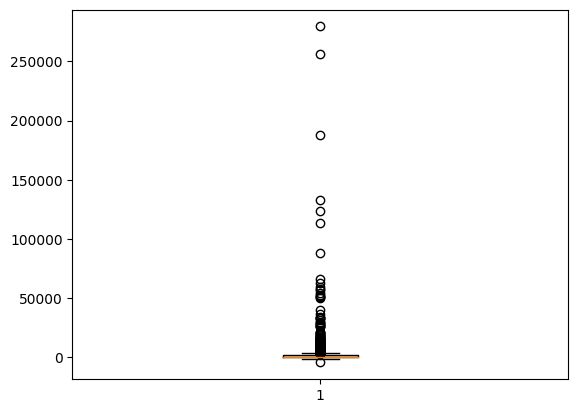

In [218]:
# box plot for amount column from RFM
plt.boxplot(RFM.Amount)

# get 25% quantile range of amount
Q1 = RFM.Amount.quantile(0.25)

# get 75% quantile range of amount
Q3 = RFM.Amount.quantile(0.75)

# get difference between first and third quantile
IQR = Q3-Q1

# remove outliers by filtering amount more than or equal to Q1-1.5*IQR and less than  or equal to Q3 + 1.5*IQR
RFM = RFM[(RFM.Amount>=Q1-1.5*IQR)&(RFM.Amount<=Q3+1.5*IQR)]

2. outlier treatment for Frequency

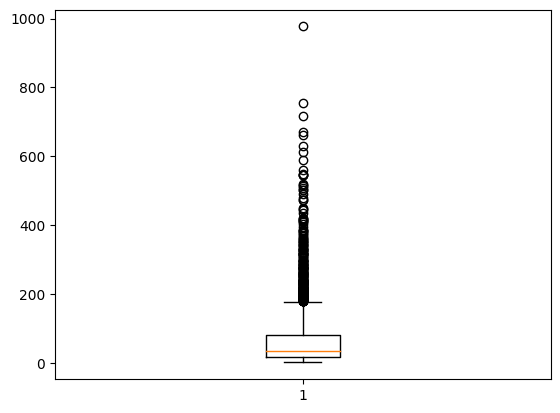

In [219]:
# box plot for frequency column from RFM
plt.boxplot(RFM.Frequency)

# get 25% quantile range of frequency
Q1 = RFM.Frequency.quantile(0.25)

# get 75% quantile range of frequency
Q3 = RFM.Frequency.quantile(0.75)

# get difference between first and third quantile
IQR = Q3-Q1

# remove outliers by filtering frequency more than or equal to Q1-1.5*IQR and less than  or equal to Q3 + 1.5*IQR
RFM = RFM[(RFM.Frequency>=Q1-1.5*IQR)&(RFM.Frequency<=Q3+1.5*IQR)]

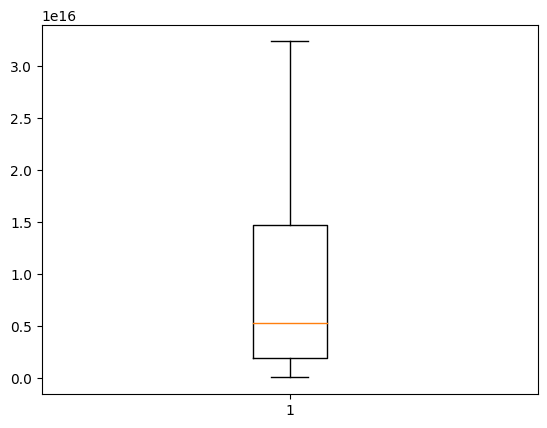

In [220]:
# box plot for recency column from RFM
plt.boxplot(RFM.Recency)

# get 25% quantile range of recency
Q1 = RFM.Recency.quantile(0.25)

# get 75% quantile range of recency
Q3 = RFM.Recency.quantile(0.75)

# get difference between first and third quantile
IQR = Q3-Q1

# remove outliers by filtering recency more than or equal to Q1-1.5*IQR and less than  or equal to Q3 + 1.5*IQR
RFM = RFM[(RFM.Recency>=Q1-1.5*IQR)&(RFM.Recency<=Q3+1.5*IQR)]

In [221]:
# drop 'CustomerID' from RFM
RFM1 = RFM.drop('CustomerID',axis=1)

# extract from column Recency and update your Recency column
RFM1.Recency = RFM1.Recency.dt.days
RFM1.head()

,Amount,Frequency,Recency
0,0.00,2,326
2,1797.24,31,75
3,1757.55,73,19
4,334.40,17,310
5,1545.41,95,36


Scaling the RFM1 data 

in order to bring all the features in to specific scale ( or ) transforming our data so that it fits within a specific scale,

In [222]:
from sklearn.preprocessing import StandardScaler
scal = StandardScaler()

# fit_transform  RFM1
RFM1 = scal.fit_transform(RFM1)


In [223]:
# save RFM1 into a DataFrame
RFM1 = pd.DataFrame(RFM1)

# change columns names
RFM1.columns = ['Amount','Frequency','Recency']
RFM1.head()

,Amount,Frequency,Recency
0,-1.041614,-1.070949,2.136422
1,1.385298,-0.375498,-0.282050
2,1.331702,0.631707,-0.821629
3,-0.590055,-0.711233,1.982257
4,1.045238,1.159290,-0.657828


Hopkins Statistics:

The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

In [224]:
# function to calculate Hopkins score
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    # d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [225]:
# use hopkins() function on RFM_norm1 
hopkins(RFM1)

0.8875747466546248

here I am going with the Kmeans algorithem because K-means clustering, hierarchical clustering also groups together the data points with similar characteristics. In some cases the result of hierarchical and K-Means clustering can be similar.

In [226]:
# to perform KMeans clustering 
from sklearn.cluster import KMeans

# kmeans with K=5, max_iter as 50 and random_state as 1
model_clus5 = KMeans(n_clusters=5,max_iter=50,random_state=1)

# fit Kmeans on RFM_norm1
model_clus5.fit(RFM1)

KMeans(max_iter=50, n_clusters=5, random_state=1)

Optimal K value

1. Silhouette Analysis

In [227]:
# import silhouette_score
from sklearn.metrics import silhouette_samples,silhouette_score

# initialise empty array to append result
sse_ = []

# iterate over different k values (here 2 to 15)
for k in range(2, 15):
    
# fit KMeans on different k values with max_iter=50, random_state=1
    kmeans = KMeans(n_clusters=k,max_iter=50,random_state=1).fit(RFM1)
    
    # append silhouette_score for every k value
    sse_.append([k,silhouette_score(RFM1,kmeans.labels_)])

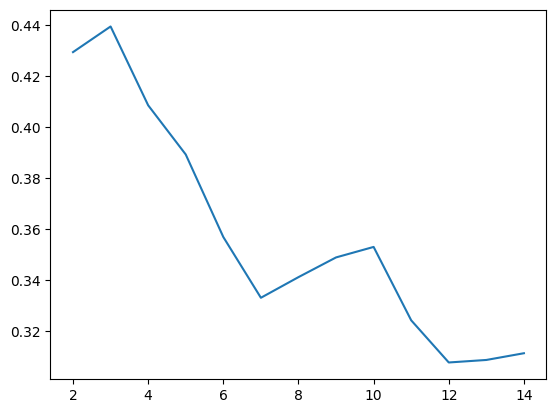

In [228]:
# plot K vs silhouette_score
plt.plot(pd.DataFrame(sse_)[0],pd.DataFrame(sse_)[1])


Above plot shows best silhouette_score on cluster number 3

2. Elbow Method

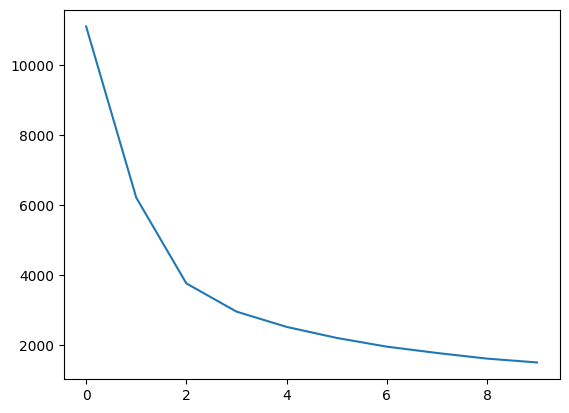

In [229]:
# sum of squared distances
# initialise empty array to store score
ssd = []

# iterate for different k values ( from 1 to 21)
for num_clusters in list(range(1,11)):
    
# instantiate K means for different k values and max_iter as 50 and random state as 42
    model_clus = KMeans(n_clusters=num_clusters,max_iter=50,random_state=42)
    
    # fir above model with RFM_norm1
    model_clus.fit(RFM1)
    
    # calculate sum of squared distances and append in ssd (Use: inertia_ on model_clus)
    ssd.append(model_clus.inertia_)
    

# plot ssd
plt.plot(ssd)
plt.show()

the above elbow is clear at k = 3. However, this choice is ambiguous as we could choose k to be either 2 or 3. In such an ambiguous case, we may use the Silhouette Method.


So now again train and fit with the K=3

In [230]:
# to perform KMeans clustering 
from sklearn.cluster import KMeans

# kmeans with K=5, max_iter as 50 and random_state as 1
model_clus5 = KMeans(n_clusters=3,max_iter=50,init = 'k-means++',random_state=42)

# fit Kmeans on RFM_norm1
model_clus5.fit(RFM1)

KMeans(max_iter=50, n_clusters=3, random_state=42)

In [231]:
y_kmeans = model_clus5.predict(RFM1)

In [232]:
RFM1 = RFM1.values

Scatter plot for all clusters formed

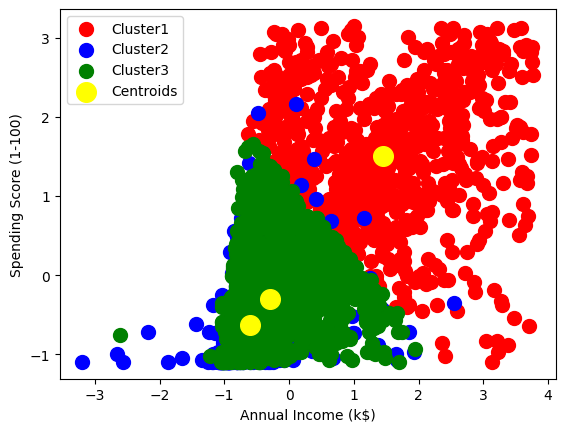

In [233]:
plt.scatter(RFM1[y_kmeans == 0, 0], RFM1[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster1')
plt.scatter(RFM1[y_kmeans == 1, 0], RFM1[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster2')
plt.scatter(RFM1[y_kmeans == 2, 0], RFM1[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster3')
# plt.scatter(RFM1[y_kmeans == 3, 0], RFM1[y_kmeans == 3, 1], s = 60, c = 'violet', label = 'Cluster4')
# plt.scatter(RFM1[y_kmeans == 4, 0], RFM1[y_kmeans == 4, 1], s = 60, c = 'yellow', label = 'Cluster5') 
plt.scatter(model_clus5.cluster_centers_[:, 0], model_clus5.cluster_centers_[:, 1], s = 200, c = 'yellow', label = 'Centroids')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)') 
plt.legend() 

plt.show()

Silhouetter Score

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [235]:
score = silhouette_score(RFM1, model_clus5.labels_, metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.439


For the deployment purpose we uses pickel to store our trained data

In [234]:
import pickle
# open a file, where you ant to store the data
file = open('kmeans_model.pkl', 'wb')

# dump information to that file
pickle.dump(model_clus5, file)

Conclusion 

We have got the optimal clusters with best score for Kmeans and we can move forward for deployments.   